# Naive model performance

Make plots for showing the performance of the model.

In [1]:
import timm
import json
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

sns.set(style="whitegrid")

tqdm.pandas()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set up PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

# Set seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Define the directory for end-to-end models
MODELS_DIR = os.path.join(DATA_DIR, 'models', 'mse_num_top_epochs=0_num_full_epochs=20')
if not os.path.exists(MODELS_DIR):
    raise FileNotFoundError(f"Models directory not found at {MODELS_DIR}")

folds = ['A', 'B', 'C', 'D', 'E']

# Load the dataset with predictions
df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
with open(os.path.join(MODELS_DIR, 'correction_values.json'), 'r') as f:
    correction_values = json.load(f)

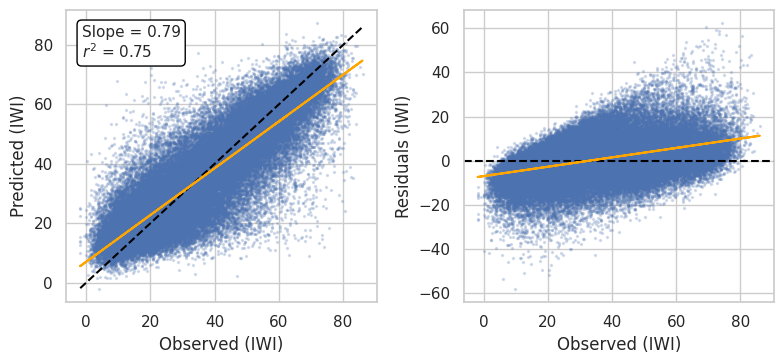

In [3]:
plt.figure(figsize=(8, 3.8))

plt.subplot(1, 2, 1)
plt.scatter(df['iwi'], df['iwi_hat'], alpha=0.2, s=2)
plt.plot([df['iwi'].min(), df['iwi'].max()], [df['iwi'].min(), df['iwi'].max()], color='black', linestyle='--')

# Add a box with R^2 and Regression coefficient slope
r2 = r2_score(df['iwi'], df['iwi_hat'])
slope_model = LinearRegression().fit(df['iwi'].values.reshape(-1, 1), df['iwi_hat'])

# Add label with slope and R^2 to plot
plt.text(0.05, 0.95, f'Slope = {slope_model.coef_[0]:.2f}\n$r^2$ = {r2:.2f}', transform=plt.gca().transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot(df['iwi'], slope_model.predict(df['iwi'].values.reshape(-1, 1)), color='orange', label='Regression Line')

plt.xlabel(r'Observed (IWI)')
plt.ylabel(r'Predicted (IWI)')

plt.subplot(1, 2, 2)
plt.scatter(df['iwi'], df['iwi'] - df['iwi_hat'], alpha=0.2, s=2)
plt.axhline(0, color='black', linestyle='--', label='Ideal')

resid_slope_model = LinearRegression().fit(df['iwi'].values.reshape(-1, 1), (df['iwi'] - df['iwi_hat']))
plt.plot(df['iwi'], resid_slope_model.predict(df['iwi'].values.reshape(-1, 1)), color='orange', label='Fitted')
plt.xlabel('Observed (IWI)')
plt.ylabel('Residuals (IWI)')

plt.tight_layout()
plt.show()

## Plot metrics

In [3]:
with open(os.path.join(MODELS_DIR, 'metrics.json'), 'r') as f:
    metrics = json.load(f)

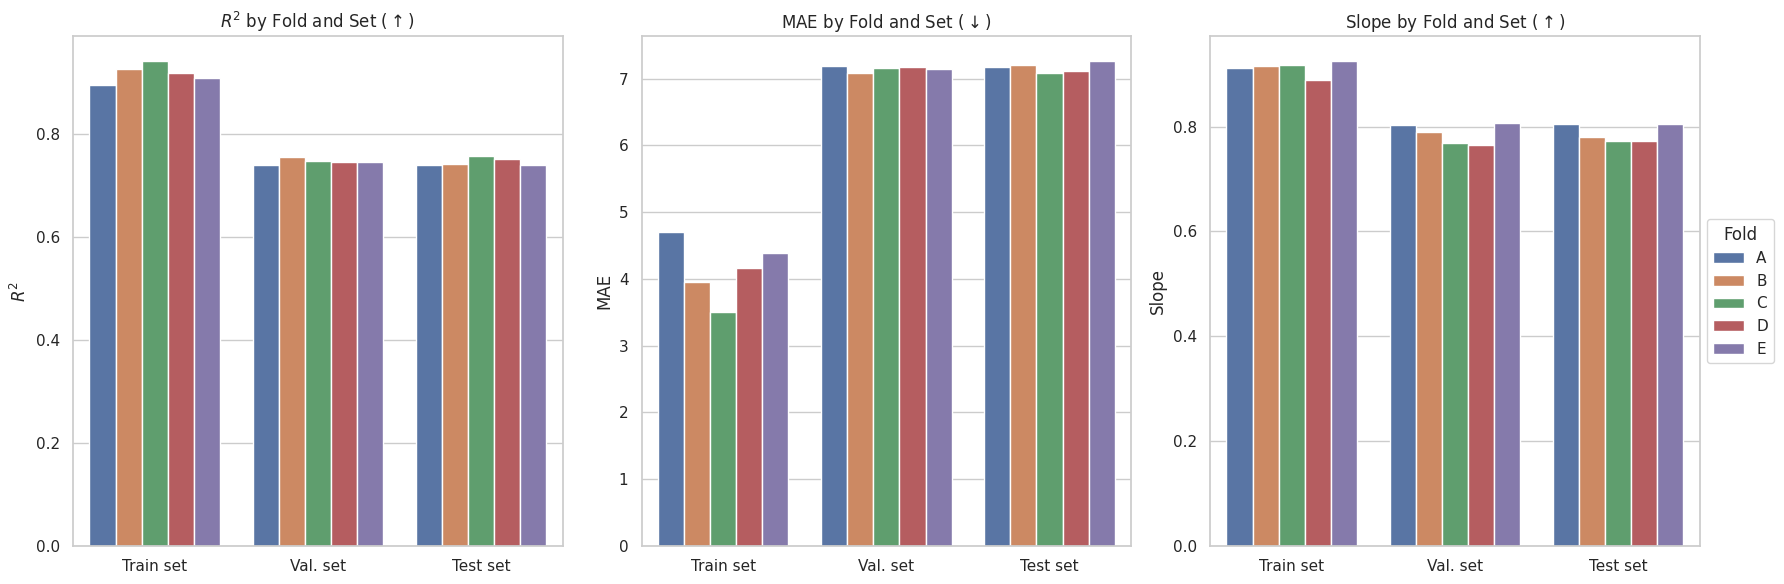

In [4]:
def plot_metrics(metrics):
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.index.name = 'Fold'
    metrics_df.reset_index(inplace=True)

    # Separate R^2 and MAE metrics
    r2_metrics = metrics_df[['Fold', 'train_r2', 'val_r2', 'test_r2']].melt(id_vars='Fold', var_name='Set', value_name='R^2')
    mae_metrics = metrics_df[['Fold', 'train_mae', 'val_mae', 'test_mae']].melt(id_vars='Fold', var_name='Set', value_name='MAE')
    coef_metrics = metrics_df[['Fold', 'train_reg_coef', 'val_reg_coef', 'test_reg_coef']].melt(id_vars='Fold', var_name='Set', value_name='Slope')

    # Rename the 'Set' values for better readability
    r2_metrics['Set'] = r2_metrics['Set'].str.replace('train_r2', 'Train set').str.replace('val_r2', 'Val. set').str.replace('test_r2', 'Test set')
    mae_metrics['Set'] = mae_metrics['Set'].str.replace('train_mae', 'Train set').str.replace('val_mae', 'Val. set').str.replace('test_mae', 'Test set')
    coef_metrics['Set'] = coef_metrics['Set'].str.replace('train_reg_coef', 'Train set').str.replace('val_reg_coef', 'Val. set').str.replace('test_reg_coef', 'Test set')

    # Plot R^2 metrics
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    sns.barplot(data=r2_metrics, x='Set', y='R^2', hue='Fold')
    plt.title(r'$R^2$ by Fold and Set ($\uparrow$)')
    plt.xlabel('')
    plt.ylabel(r'$R^2$')
    plt.legend().remove()

    # Plot MAE metrics
    plt.subplot(1, 3, 2)
    sns.barplot(data=mae_metrics, x='Set', y='MAE', hue='Fold')
    plt.title(r'MAE by Fold and Set ($\downarrow$)')
    plt.xlabel('')
    plt.ylabel('MAE')
    plt.legend().remove()

    # Plot Regression Coefficient metrics
    plt.subplot(1, 3, 3)
    sns.barplot(data=coef_metrics, x='Set', y='Slope', hue='Fold')
    plt.title(r'Slope by Fold and Set $(\uparrow)$')
    plt.xlabel('')
    plt.ylabel('Slope')
    plt.legend(title='Fold', loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)

In [8]:
r2s = [metrics[fold]['test_r2'] for fold in folds]
print(np.min(r2s), np.max(r2s))

0.7402160326889244 0.7580188452881532
